In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

%matplotlib inline

dfs = [pd.read_csv(f"survey_results/survey_{i}.csv") for i in range(2018, 2021)]
dfs[0].head()


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [176]:
# compute total number of responses summing over all years
total_responses = 0
for df in dfs:
    total_responses += df.shape[0]
    
total_responses

252199

In [ ]:
"""
First, we will find out the count of languages worked with and which are loved and which are dreaded
"""

In [107]:
def count_worked_languages(df):
    """
    Returns a Counter of languages that developers are currently working with
    """
    data = df["LanguageWorkedWith"].dropna()
    languages = []
    languages = []
    for row in data:
        languages += [x.strip() for x in row.split(';')]
    return Counter(languages)

In [106]:
def count_loved_dreaded_languages(df):
    """
    Returns a tuple of Counters of loved and dreaded languages
    Loved: developers who are currently working with and express desire to work with next year
    Dreaded: developers who are currently working with and express no desire to work with next year
    """
    # drop rows where both columns have no values
    df = df.dropna(subset=["LanguageWorkedWith", "LanguageDesireNextYear"], how="all")
    data = df[["LanguageWorkedWith", "LanguageDesireNextYear"]]

    loved_languages = []
    dreaded_languages = []
    for row in data.iterrows():
        data_row = row[1]
        
        worked_with = []
        desired_next_year = []

        if not pd.isna(data_row["LanguageWorkedWith"]):
            worked_with = [lang.strip() for lang in data_row["LanguageWorkedWith"].split(';')]
        
        if not pd.isna(data_row["LanguageDesireNextYear"]):
            desired_next_year = [lang.strip() for lang in data_row["LanguageDesireNextYear"].split(';')]
            
        for lang in worked_with:
            if lang in desired_next_year:
                loved_languages.append(lang)
            else:
                dreaded_languages.append(lang)
        
    return Counter(loved_languages), Counter(dreaded_languages)

In [117]:
worked_with_counters = [count_worked_languages(df) for df in dfs]

In [ ]:
loved_dreaded_counters = [count_loved_dreaded_languages(df) for df in dfs]

In [101]:
"""
now we have count of languages worked with, and which are loved and dreaded
using this, we can calculate the percentage of users loving and dreading it and 
finally save it in the respective counters
"""

loved_counters = []
dreaded_counters = []

for idx, worked_with_counter in enumerate(worked_with_counters):
    loved_counter = Counter()
    dreaded_counter = Counter()
    for lang, cnt in worked_with_counter.items():
        if cnt != 0:
            loved_counter[lang] = loved_dreaded_counters[idx][0][lang] / cnt * 100
            dreaded_counter[lang] = loved_dreaded_counters[idx][1][lang] / cnt * 100
    loved_counters.append(loved_counter)
    dreaded_counters.append(dreaded_counter)

In [118]:
"""
converting count of worked languages to percentages
"""

_worked_with_counters = []

for idx, counter in enumerate(worked_with_counters):
    _counter = Counter()
    for lang, cnt in counter.items():
        _counter[lang] = (cnt / dfs[idx].shape[0]) * 100
    _worked_with_counters.append(_counter)
    
worked_with_counters = _worked_with_counters

In [119]:
# see the results

loved_counters[2].most_common(5)
dreaded_counters[2].most_common(5)
worked_with_counters[2].most_common(5)

[('JavaScript', 60.2255627433642),
 ('HTML/CSS', 56.1285118133445),
 ('SQL', 48.731791315679246),
 ('Python', 39.2283706427142),
 ('Java', 35.79528707280371)]

In [174]:
def plot_bar_chart(data, xticks, xlabel, ylabel, title):
#     plt.figure(figsize=(10, 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.bar(range(len(data)), data, align="center")
    plt.xticks(range(len(xticks)), xticks)
    plt.show()

In [170]:
def plot_counters_chart(counters, title):
    for idx, counter in enumerate(counters):
        year = idx + 2018
        data = dict(counter.most_common(5))
        plot_bar_chart(data.values(), data.keys(), "Language", "% of Users", f'{title} in year {year}')

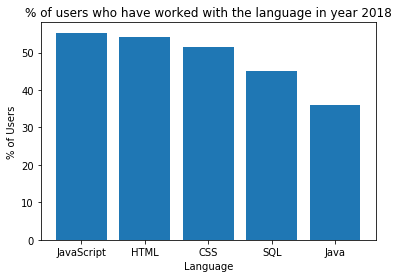

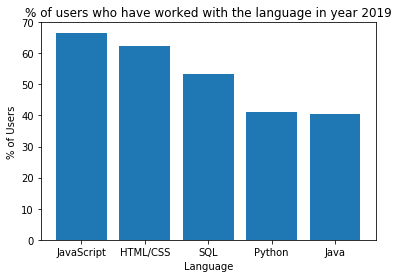

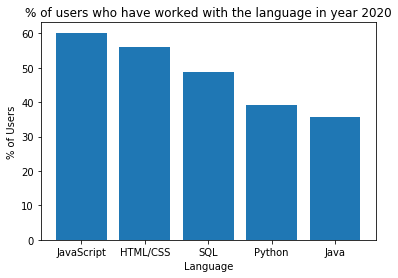

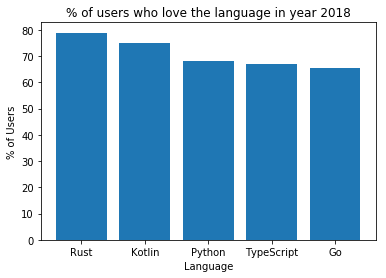

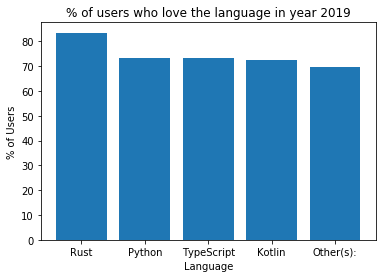

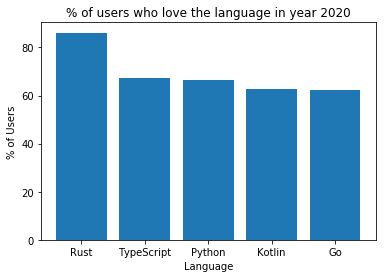

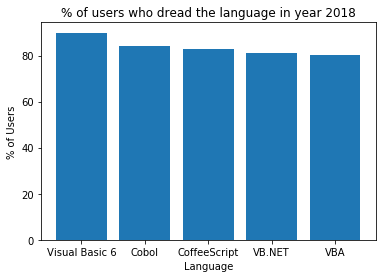

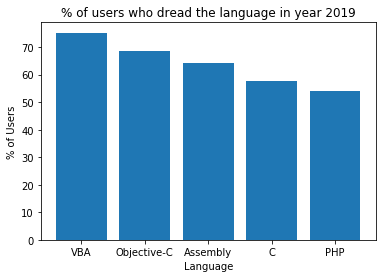

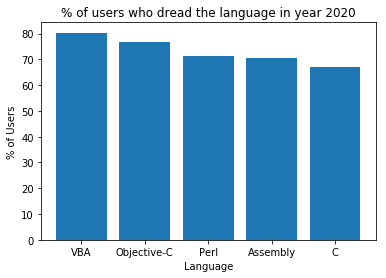

In [175]:
"""
Plot charts for all counters
"""

plot_counters_chart(worked_with_counters, "% of users who have worked with the language")
plot_counters_chart(loved_counters, "% of users who love the language")
plot_counters_chart(dreaded_counters, "% of users who dread the language")

In [59]:
"""
Next, we find out the salary associated with each language
"""

In [165]:
def compute_language_median(df, language, salary_col):
    """
    Computes the median salary for the language
    """

    # drop all rows where LanguageWorkedWith or Salary is null
    df = df.dropna(subset=["LanguageWorkedWith", salary_col])
    
    # clean values which are not float
    def is_float(x):
        try:
            float(x)
        except ValueError:
            return False
        return True
    df = df[df[salary_col].apply(is_float)]
    
    # filter to rows where LanguageWorkedWith contains the language
    df = df[df["LanguageWorkedWith"].str.contains(language)]
    df = df[["LanguageWorkedWith", salary_col]]

    if df.empty:
        return 0
    return df[salary_col].astype('float').median()

In [131]:
"""
The below variable contains the list of all languages picked from the year 2020
"""

all_languages = [
    "Assembly",
    'Bash/Shell/PowerShell',
    'C',
    'C#',
    'C++',
    'Dart',
    'Go',
    'Haskell',
    'HTML/CSS',
    'Java',
    'JavaScript',
    'Julia',
    'Kotlin',
    'Objective-C',
    'Perl',
    'PHP',
    'Python',
    'R',
    'Ruby',
    'Rust',
    'Scala',
    'SQL',
    'Swift',
    'TypeScript',
    'VBA'
]

In [166]:
top_salaries = {}

for year in range(2018, 2021):
    top_salaries[year] = {}
    for lang in all_languages:
        avg_salary = compute_language_median(
            dfs[year-2018],
            re.escape(lang),
            "ConvertedComp" if year != 2018 else "Salary"
        )
        top_salaries[year][lang] = avg_salary

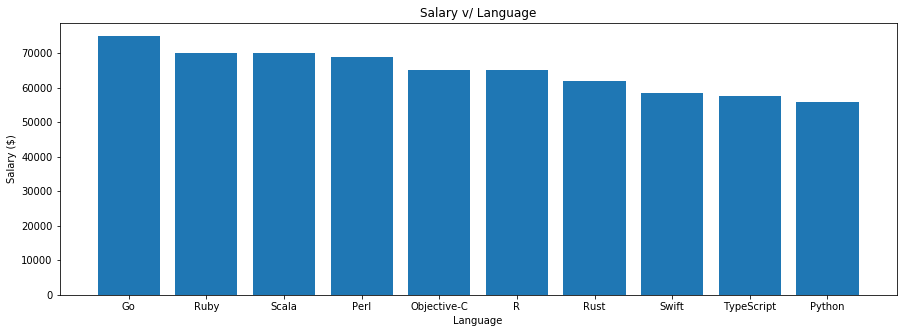

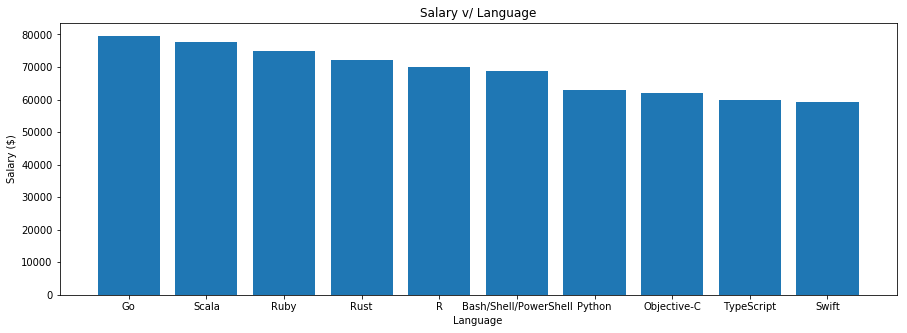

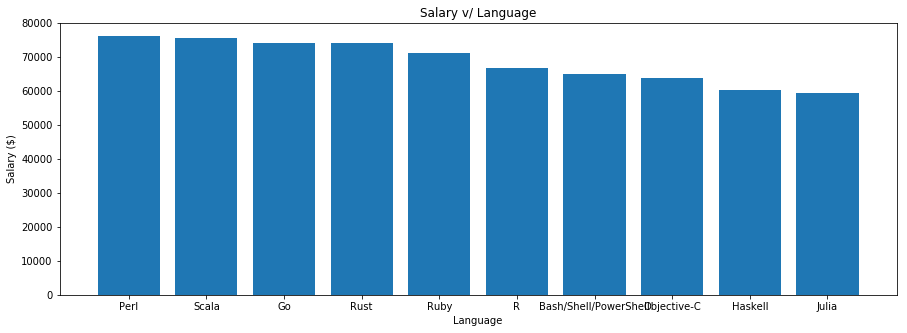

In [169]:
for year, lang_dict in top_salaries.items():
    data = Counter(dict(Counter(lang_dict).most_common(10)))
    plot_bar_chart(data.values(), data.keys(), "Language", "Salary ($)", "Salary v/ Language")